In [1]:
from queries import get_data
from preprocessing import preprocessing
from utils import *

In [2]:
# TODO
# Intake time-series data / Load data
# EDA (on values)
# plot time series plots (i.e. seasonal decomposition, etc.)
# plot acf/pcf


In [3]:
df = get_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884 entries, 0 to 883
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   ID           884 non-null    object             
 1   Country      884 non-null    object             
 2   CountryCode  884 non-null    object             
 3   Province     884 non-null    object             
 4   City         884 non-null    object             
 5   CityCode     884 non-null    object             
 6   Lat          884 non-null    object             
 7   Lon          884 non-null    object             
 8   Confirmed    884 non-null    int64              
 9   Deaths       884 non-null    int64              
 10  Recovered    884 non-null    int64              
 11  Active       884 non-null    int64              
 12  Date         884 non-null    datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(4), object(8)
memory usage: 96.7+ KB


In [5]:
df.describe()

,Confirmed,Deaths,Recovered,Active
count,8.840000e+02,884.000000,8.840000e+02,8.840000e+02
mean,1.085264e+06,19080.470588,2.989235e+05,8.008399e+05
std,1.042768e+06,10822.879240,4.577997e+05,1.155665e+06
min,2.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.155272e+05,9063.750000,0.000000e+00,0.000000e+00
50%,8.946150e+05,21950.000000,4.043100e+04,8.651500e+03
75%,1.427778e+06,26297.750000,4.532852e+05,1.401481e+06
max,3.351691e+06,37270.000000,1.405971e+06,3.314421e+06


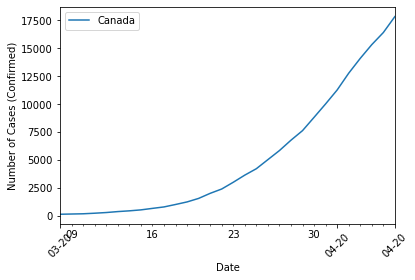

In [7]:
plot_initial_growth(['Canada']);  # To be added in utils.plotting

In [ ]:
df = preprocessing(df)  # dtype conversions etc.

In [ ]:
X, y = df["Date"], df["Active"]  # choose simple expl/resp vars

In [ ]:
# Model selection/diagnostic

In [ ]:
# Train/fit

In [ ]:
# Predict + Predict Viz

In [ ]:
# Evaluation